In [1]:
All this codes are based on what I found on the website : 
https://arsenous.wordpress.com/2013/03/22/221/


In [ ]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d as conv2
from numpy.fft  import fft,ifft
import scipy as sp
import os
import scipy.fftpack

plt.gray()

In [3]:
def filetomatrix(filename,verbose=False):

    file = open(filename, "r")
    txt = file.read()
    txt=txt.split()
    nx=int(txt[1])
    ny=int(txt[2])
    if(verbose):print("nx=",nx,", ny=",ny)
    b=sp.zeros([nx,ny])
    if(verbose):print("size=",b.size,'\n')
    for i in range(nx):
        for j in range(ny):
            b[i,j]=txt[i+3+nx*j]
            if(verbose):print(str(i)+" : ",b[i])
                
    if(verbose):print('\n\n')      
    return b

def arraytofile(Img,scale=1,filename="testimg.txt",slope=0,pixel_size=1):
    file= open(filename,"w+")
    a,b=Img.shape
    if len(filename)<4:filename+=".txt"
    else:
        if(filename[-4:]!=".txt"):
            if ('.'in filename) : filename=filename.replace(filename[filename.index("."):], '.txt')
            else:filename+=".txt"
    
    file.write('0 '+str(a)+' '+str(b)+' ')
    for i in range(a):
      for j in range(b):
        file.write(str(Img[i][j]*scale+i*slope*pixel_size)+' ')
    file.close()
    os.system("txttohbf.exe "+filename)
    filename=filename.replace( '.txt','.hbf')
    
    return
  
def compute_div(x_slope_filename,y_slope_filename,has_been_computed=False):

    if(not has_been_computed): 
        
#         px=filetomatrix(x_slope_filename,verbose=False)
#         py=filetomatrix(y_slope_filename,verbose=False)
#         div=np.gradient(px)[0]+np.gradient(py)[1]

        pxbis=np.zeros([px.shape[0]+4,px.shape[1]+4])
        pxbis[2:-2,2:-2]=px
        pybis=np.zeros([py.shape[0]+4,py.shape[1]+4])
        pybis[2:-2,2:-2]=py
        div=np.zeros([px.shape[0]+2,px.shape[1]+2])

        for i in range(1,pxbis.shape[0]-1):
            for j in range(1,pxbis.shape[1]-1):
                div[i-1,j-1]=(pxbis[i+1,j]-pxbis[i-1,j] + pybis[i,j+1]-pybis[i,j-1])/2

        print(div.shape) 
        div=div[1:-1,1:-1]
        print(div.shape)
        div-=np.mean(div)
        print(np.mean(div))

        arraytofile(div,scale=1,filename="div.txt",kip_txt=True)

    else : div= filetomatrix("div.txt")

    have_been_computed=True
    
    return div

In [4]:
def dst(x,axis=-1):
    """Discrete Sine Transform (DST-I)

    Implemented using 2(N+1)-point FFT
    xsym = r_[0,x,0,-x[::-1]]
    DST = (-imag(fft(xsym))/2)[1:(N+1)]

    adjusted to work over an arbitrary axis for entire n-dim array
    """
    n = len(x.shape)
    N = x.shape[axis]
    slices = [None]*3
    for k in range(3):
        slices[k] = []
        for j in range(n):
            slices[k].append(slice(None))
    newshape = list(x.shape)
    newshape[axis] = 2*(N+1)
    xsym = np.zeros(newshape,np.float)
    slices[0][axis] = slice(1,N+1)
    slices[1][axis] = slice(N+2,None)
    slices[2][axis] = slice(None,None,-1)
    for k in range(3):
        slices[k] = tuple(slices[k])
    xsym[slices[0]] = x
    xsym[slices[1]] = -x[slices[2]]
    DST = fft(xsym,axis=axis)
    #print xtilde
    return (-(DST.imag)/2)[slices[0]]

In [5]:
def dst2(x,axes=(-1,-2)):
    return dst(dst(x,axis=axes[0]),axis=axes[1])

def idst2(x,axes=(-1,-2)):
    return dst(dst(x,axis=axes[0]),axis=axes[1])

In [6]:
def fft_poisson(f,h):

    m,n=f.shape
    f_bar=np.zeros([m,n])
    u_bar = f_bar #make of the same shape
    u = u_bar
    f_bar=idst2(f)      # f_bar= sine transform of f
    pi=np.pi
    lamx = np.arange(1,n+1)
    lamx = -4/h**2 * (np.sin((lamx*pi) / (2*(n + 1))))**2 
    lamy = np.arange(1,m+1)
    lamy = -4/h**2 * (np.sin((lamy*pi) / (2*(m + 1))))**2
    for i in range(0,m):
            u_bar[i,:] = (f_bar[i,:]) / (lamy[i] + lamx[:])

    u=dst2(u_bar)    #sine transform back
    u= u * (2/(n+1))*(2/(m+1))	#normalize 
    return u

In [7]:
#real data
div=compute_div('22.txt','32.txt',has_been_computed=True)

mask=np.array([[0.,-1.,0.],[-1.,4.,-1.],[0.,-1.,0.]])
f= div# conv2(Img[:600,:800],mask,'same') # div#  
m,n=f.shape
h=8.6e-3     #size 1
L=n*h

h2 = h**2;





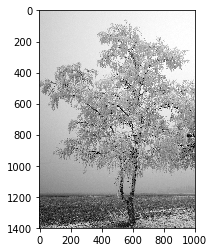

In [8]:
#picture
Img=plt.imread("hiver.jpg")
Img=Img[:1400,200:1200,0]



plt.imshow(Img)
     

mask=np.array([[0.,-1.,0.],[-1.,4.,-1.],[0.,-1.,0.]])
f= conv2(Img,mask,'same') # div#  
m,n=f.shape
h=1     #size 1
L=n*h

h2 = h**2;


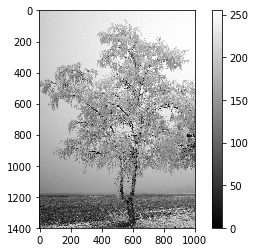

In [9]:
#solve

U=-fft_poisson(f,h)
plt.figure()


im=plt.imshow(np.real(U))
plt.colorbar(im)

#plt.contour(f)

plt.show()



In [10]:
U_orig=U.copy()
Img_orig=Img.copy()

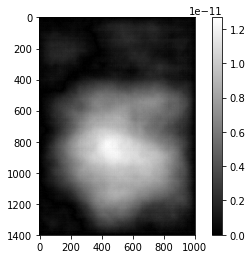

In [11]:

test=np.abs(U_orig-Img_orig)
plt.imshow(test)
# print(U_orig)
# print(test)#approx (n-2)² n=size approx quasi parf
# print(Img_orig)
plt.colorbar()

In [12]:
arraytofile(U,scale=1.,filename="U.txt",slope=1,pixel_size=8.6e-3)